* https://rhodesmill.org/skyfield/
* https://rhodesmill.org/skyfield/earth-satellites.html

In [98]:
%pip install matplotlib pandas pypredict pyorbital

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 1.8 MB/s eta 0:00:0000:0100:01
  DEPRECATION: pyorbital is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for pyorbital ... done
Note: you may need to restart the kernel to use updated packages.


In [225]:
from skyfield.api import load, wgs84, N, W, Loader
from skyfield import almanac, framelib
from skyfield.units import AngleRate, Angle
import math
import matplotlib.pyplot as plt
import pandas as pd
from pytz import timezone
from datetime import datetime, timezone, timedelta
from matplotlib.dates import HourLocator, DateFormatter
from astropy.table import Table, hstack
from skyfield.units import Angle, Distance, AngleRate, Velocity
from skyfield.timelib import Time
from numpy.lib.type_check import nan_to_num
from geopy.geocoders import Nominatim
import time
import predict

eph = load('de421.bsp')
stations_url = 'https://celestrak.org/NORAD/elements/supplemental/sup-gp.php?FILE=starlink&FORMAT=tle'
#stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellites = load.tle_file(stations_url)
print('Loaded', len(satellites), 'satellites')

Loaded 3730 satellites


In [55]:
by_name = { s.name: s for s in satellites }
#satellite = by_name['ISS (ZARYA)')
#satellite = by_name['BLUEWALKER 3']
satellite = by_name['STARLINK-1303']
print(satellite)

STARLINK-1303 catalog #45396 epoch 2023-03-09 04:48:42 UTC


In [3]:
#geolocator = Nominatim()
#location = geolocator.geocode("3048 Farrior Road, Raleigh, NC 27607")

#location

In [56]:
tz = timezone('US/Eastern')

earth = eph['earth']
sun = eph['sun']
raleigh = wgs84.latlon(35.807185453343514, -78.6761513684278)
# raleigh = wgs84.latlon(location.latitude, location.longitude)
difference = satellite - raleigh

In [57]:
def event_data(t, event, satellite, eph, difference, tod):
    name = ('rise', 'peak', 'set')[event]
    topocentric = difference.at(t)
    alt, az, _ = topocentric.altaz()
    ra, dec, _ = topocentric.radec()

    return {
        'timestamp': t.utc_datetime(),
        'event': name,
        'alt': alt.degrees,
        'az': az.degrees,
        'ra': str(ra),
        'dec': str(dec),
        'ra_deg': ra._degrees,
        'dec_deg': dec._degrees,
        'is_sunlit': bool(satellite.at(t).is_sunlit(eph)),
        'is_dark': bool(tod(t).item(0)<=3),
        'time_of_day': almanac.TWILIGHTS[tod(t).item(0)]
    }

In [59]:
ts = load.timescale()

t0 = ts.from_datetime(tz.localize(datetime.now())) - .1
t1 = t0 + 3
t, events = satellite.find_events(raleigh, t0, t1, altitude_degrees=30)
tod = almanac.dark_twilight_day(eph, raleigh,)

data = pd.DataFrame.from_records([event_data(t,event,satellite,eph,difference,tod) for t, event in zip(t, events)],
                                 columns = ("timestamp", "event", "alt", "az", "ra", "dec", "is_sunlit"), index='timestamp')

data

,event,alt,az,ra,dec,is_sunlit
timestamp,,,,,,
2023-03-11 04:52:02.929833+00:00,rise,30.022306,328.636580,04h 36m 01.08s,"+63deg 07' 02.0""",False
2023-03-11 04:53:56.263115+00:00,peak,65.245929,42.178219,12h 40m 01.83s,"+51deg 39' 28.5""",False
2023-03-11 04:55:50.329485+00:00,set,29.721842,115.599555,14h 20m 36.04s,"-00deg 42' 37.8""",False
2023-03-11 22:03:43.494986+00:00,rise,30.219007,295.521977,23h 00m 02.20s,"+36deg 29' 22.0""",True
2023-03-11 22:04:38.688531+00:00,peak,33.951807,323.630032,22h 35m 07.66s,"+60deg 09' 30.1""",True
2023-03-11 22:05:36.235071+00:00,set,29.929457,352.703738,19h 23m 05.74s,"+81deg 28' 15.9""",True
2023-03-12 04:45:40.364980+00:00,rise,30.069068,314.221616,05h 07m 05.99s,"+51deg 28' 17.4""",False
2023-03-12 04:47:38.335573+00:00,peak,89.907279,49.859614,10h 50m 18.82s,"+35deg 59' 18.7""",False
2023-03-12 04:49:36.349136+00:00,set,29.956207,134.683228,13h 27m 54.84s,"-11deg 31' 53.8""",False


In [20]:
import predict

tle = """0 LEMUR 1
1 40044U 14033AL  15013.74135905  .00002013  00000-0  31503-3 0  6119
2 40044 097.9584 269.2923 0059425 258.2447 101.2095 14.72707190 30443"""
qth = (raleigh.latitude.degrees, -raleigh.longitude.degrees, 0) # lat (N), long (W), alt (meters)
predict.observe(tle, qth) # optional time argument defaults to time.time()


{'norad_id': 40044,
 'name': '0 LEMUR 1',
 'epoch': 1678508906.464523,
 'latitude': 40.260732554131934,
 'longitude': 92.89880002365919,
 'azimuth': 6.605872610301302,
 'elevation': -49.79807748335138,
 'orbital_velocity': 27307.250085283325,
 'footprint': 5271.122173105628,
 'altitude': 586.1561734055604,
 'slant_range': 10499.66504100756,
 'eclipse_depth': -65.23812470687331,
 'orbital_phase': 224.8315355638047,
 'orbital_model': 'SGP4',
 'visibility': b'D',
 'sunlit': 1,
 'orbit': 49702,
 'geostationary': 0,
 'has_aos': 1,
 'decayed': 0,
 'doppler': 1507.1564907989457,
 'eci_x': 4541.743686461303,
 'eci_y': -2772.9647775890953,
 'eci_z': 4478.934257585305,
 'eci_vx': -4.83973999440352,
 'eci_vy': 1.3467404364862379,
 'eci_vz': 5.6833704634107,
 'eci_sun_x': 146480388.4740363,
 'eci_sun_y': -22873695.545764703,
 'eci_sun_z': -9916499.895910533,
 'eci_obs_x': -4767.541672957927,
 'eci_obs_y': 2021.8488316939292,
 'eci_obs_z': 3710.862306207476,
 'beta_angle': -15.033599901793009}

In [64]:
from itertools import zip_longest

tles = []

with open(".data/stations.txt", "r") as f:
    for tle in zip_longest(*[f] * 3):
        tles.append("".join(tle))

In [131]:
import os
t_start = datetime.fromtimestamp(os.path.getmtime(".data/stations.txt"), tz=timezone.utc)
t_start.isoformat()

'2023-03-11T04:52:14.713307+00:00'

In [191]:
%matplotlib inline

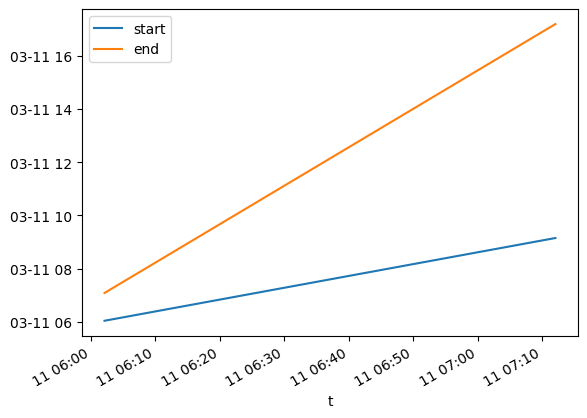

In [200]:
for tle in tles:
    if 'PHASE 3B (AO-10)' in tle:
        break

rows = []

for offset in range(0, 7201, 70*60):
    t = datetime.fromisoformat('2023-03-11 06:02:05.135715').timestamp() + offset
    
    transit = predict.quick_predict(tle, t, qth)
    rows.append({
        't': datetime.fromtimestamp(t),
        'start': datetime.fromtimestamp(transit[0]['epoch']),
        'end': datetime.fromtimestamp(transit[-1]['epoch'])
    })

pd.DataFrame.from_records(rows).set_index('t').plot();


In [159]:
print(tle)

PHASE 3B (AO-10)        
1 14129U 83058B   23063.04003898 -.00000220  00000+0  00000+0 0  9990
2 14129  26.9570  53.6764 6036830 152.7532 259.4151  2.05868990270755



In [215]:
from re import A

def transits(tle, qth, ending_after, ending_before):
    ts = ending_after
    while ts<ending_before:
        transit = predict.quick_predict(tle, ts, qth)
        t = predict.Transit(
            tle,
            qth,
            start=transit[0]["epoch"],
            end=transit[-1]["epoch"],
            _samples=transit,
        )
        if t.end > ending_after:
            yield t
        # Need to advance time cursor so predict doesn't yield same pass
        ts = t.end + 60  # seconds seems to be sufficient

preds = []

for tle in tles:
#    if 'PHASE 3B (AO-10)' not in tle: continue
#    if 'STARLINK' not in tle: continue
    try:
        for transit in transits(tle, qth, t_start.timestamp(), (t_start + timedelta(minutes=60)).timestamp()):
            transit = transit.above(30)
            if transit.duration() > 0:
                peak = transit.peak()
                preds.append({
                    'id': peak['norad_id'],
                    'name': peak['name'],
                    'start_at': datetime.fromtimestamp(transit.start), 
                    'peak_at': datetime.fromtimestamp(peak['epoch']),
                    'end_at': datetime.fromtimestamp(transit.end), 
                    'peak_alt': peak['elevation'],
                    'duration': transit.duration(),
                    'geostationary': peak['geostationary'],
                    'orbital_model': peak['orbital_model'],
                    'orbital_velocity': peak['orbital_velocity'],
                    'range': peak['slant_range'],
                    'sunlit': peak['sunlit']})
                
            if len(preds)==10: break
    except Exception as e:
        print(e)

pd.DataFrame.from_records(preds).sort_values(by='peak_at')

1678510334.713307
1678510334.713307
1678510334.713307
1678512995.411978
1678510334.713307
1678510334.713307
1678511436.9611442
1678510334.713307
1678511641.753132
1678510334.713307
1678510334.713307
1678511665.7881334
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
19548 is geostationary.  Does not transit.

1678510334.713307
1678510334.713307
1678510334.713307
20253 is geostationary.  Does not transit.

1678510334.713307
1678510334.713307
1678510334.713307
20776 is geostationary.  Does not transit.

1678510334.713307
21639 is geostationary.  Does not transit.

1678510334.713307
1678510334.713307
22314 is geostationary.  Does not transit.

1678510334.713307
1678511734.4573655
1678510334.713307
22787 is geostationary.  Does not transit.

1678510334.713307
1678510334.713307
1678510334.713307
1678510334.713307
22988 is geostationary.  Does not transit.

16785

KeyboardInterrupt: 

In [252]:
preds = []

for tle in tles:
#    if 'PHASE 3B (AO-10)' not in tle: continue
    if 'STARLINK' not in tle: continue
    try:
        samples = predict.quick_predict(tle, t_start.timestamp(), qth)
        transit = predict.Transit(
            tle,
            qth,
            start=samples[0]["epoch"],
            end=samples[-1]["epoch"],
            _samples=samples,
        )
        transit = transit.above(30)
        if transit.duration() > 0 and transit.start>t_start.timestamp() and transit.end<t_start.timestamp()+3600:
            peak = transit.peak()
            preds.append({
                'id': peak['norad_id'],
                'name': peak['name'],
                'start_at': datetime.fromtimestamp(transit.start, tz=timezone.utc), 
                'peak_at': datetime.fromtimestamp(peak['epoch'], tz=timezone.utc),
                'end_at': datetime.fromtimestamp(transit.end, tz=timezone.utc), 
                'peak_alt': peak['elevation'],
                'duration': transit.duration(),
                'geostationary': peak['geostationary'],
                'orbital_model': peak['orbital_model'],
                'orbital_velocity': peak['orbital_velocity'],
                'range': peak['slant_range'],
                'sunlit': peak['sunlit']})
    except Exception as e:
        print(e)

pd.DataFrame.from_records(preds).sort_values(by='end_at')

55606 has decayed. Cannot calculate transit.



,id,name,start_at,peak_at,end_at,peak_alt,duration,geostationary,orbital_model,orbital_velocity,range,sunlit
216,52668,STARLINK-4067,2023-03-11 04:52:38.041768+00:00,2023-03-11 04:53:40.337673+00:00,2023-03-11 04:54:42.512024+00:00,35.039904,124.470256,0,SGP4,27350.805224,878.327172,0
121,48591,STARLINK-2248,2023-03-11 04:53:17.805568+00:00,2023-03-11 04:54:07.012682+00:00,2023-03-11 04:54:56.219797+00:00,32.920460,98.414229,0,SGP4,27333.538406,927.693061,0
242,53594,STARLINK-4681,2023-03-11 04:54:23.879858+00:00,2023-03-11 04:54:46.740851+00:00,2023-03-11 04:55:09.601844+00:00,30.578973,45.721986,0,SGP4,27346.821796,968.101631,0
185,52577,STARLINK-3836,2023-03-11 04:52:39.107553+00:00,2023-03-11 04:54:03.592130+00:00,2023-03-11 04:55:27.911859+00:00,41.566845,168.804307,0,SGP4,27346.166153,778.668874,0
233,52707,STARLINK-4007,2023-03-11 04:52:57.812336+00:00,2023-03-11 04:54:19.351948+00:00,2023-03-11 04:55:40.732458+00:00,40.715225,162.920122,0,SGP4,27358.747125,782.100354,0
...,...,...,...,...,...,...,...,...,...,...,...,...
218,52673,STARLINK-3976,2023-03-11 05:46:56.878986+00:00,2023-03-11 05:48:51.364027+00:00,2023-03-11 05:50:45.514153+00:00,73.852337,228.635167,0,SGP4,27347.136807,561.870044,0
273,53866,STARLINK-4762,2023-03-11 05:47:43.080847+00:00,2023-03-11 05:49:20.846492+00:00,2023-03-11 05:50:58.803271+00:00,48.400119,195.722425,0,SGP4,27344.538036,704.899727,0
31,46141,STARLINK-1596,2023-03-11 05:47:29.854753+00:00,2023-03-11 05:49:17.419633+00:00,2023-03-11 05:51:05.300107+00:00,57.110150,215.445354,0,SGP4,27330.317381,643.740668,0
109,48131,STARLINK-2473,2023-03-11 05:48:32.975577+00:00,2023-03-11 05:50:19.392465+00:00,2023-03-11 05:52:05.498041+00:00,55.591808,212.522464,0,SGP4,27333.615197,652.717139,0


In [251]:
passes = []
coords = wgs84.latlon(35.807185453343514 * N, 78.6761513684278 * W)

for satellite in satellites:

    if not "STARLINK" in satellite.name: continue

    difference = satellite - coords

    t, events = satellite.find_events(coords, ts.from_datetime(t_start), ts.from_datetime(t_start + timedelta(minutes=60)), altitude_degrees=30.0)

    curr = None
    for event in [event_data(t,event,satellite,eph,difference,tod) for t, event in zip(t, events)]:
        if event['event']=='rise':
            curr = {
                'id': satellite.model.satnum,
                'name': satellite.name,
                'rise': event['timestamp']}
        elif event['event']=='peak' and curr:
            curr['peak'] = event['timestamp']
            curr['peak_alt'] = event['alt']
            curr['is_visible'] = event['is_sunlit']
        elif event['event']=='set'and curr and 'peak' in curr :
            curr['set'] = event['timestamp']
#            curr['is_visible'] = curr['peak']['is_sunlit'] and curr['peak']['is_dark']
            passes.append(curr)

pd.DataFrame.from_records(passes).sort_values(by='set')

,id,name,rise,peak,peak_alt,is_visible,set
216,52668,STARLINK-4067,2023-03-11 04:52:30.333466+00:00,2023-03-11 04:53:32.361696+00:00,35.007968,False,2023-03-11 04:54:39.111766+00:00
121,48591,STARLINK-2248,2023-03-11 04:53:13.546590+00:00,2023-03-11 04:54:03.206952+00:00,32.977369,False,2023-03-11 04:54:54.103517+00:00
242,53594,STARLINK-4681,2023-03-11 04:54:21.973658+00:00,2023-03-11 04:54:44.972567+00:00,30.587464,False,2023-03-11 04:55:10.116386+00:00
185,52577,STARLINK-3836,2023-03-11 04:52:36.192055+00:00,2023-03-11 04:54:00.716360+00:00,41.600946,False,2023-03-11 04:55:27.302251+00:00
233,52707,STARLINK-4007,2023-03-11 04:52:57.755687+00:00,2023-03-11 04:54:19.300085+00:00,40.711339,False,2023-03-11 04:55:45.425428+00:00
...,...,...,...,...,...,...,...
218,52673,STARLINK-3976,2023-03-11 05:46:51.241347+00:00,2023-03-11 05:48:45.637428+00:00,73.984034,False,2023-03-11 05:50:39.716632+00:00
273,53866,STARLINK-4762,2023-03-11 05:47:48.100222+00:00,2023-03-11 05:49:25.678772+00:00,48.335055,False,2023-03-11 05:51:03.557219+00:00
31,46141,STARLINK-1596,2023-03-11 05:47:32.882924+00:00,2023-03-11 05:49:20.505917+00:00,57.204757,False,2023-03-11 05:51:08.557554+00:00
144,49729,STARLINK-3251,2023-03-11 05:48:09.700507+00:00,2023-03-11 05:50:04.378944+00:00,74.052326,False,2023-03-11 05:51:58.889608+00:00


In [220]:


for satellite in satellites:
    if not "STARLINK" in satellite.name: continue
    satellite.find_events(raleigh, t0, t1, altitude_degrees=30)

In [27]:
import cProfile
import pstats
import io
from pstats import SortKey

ob = cProfile.Profile()
ob.enable()

for satellite in satellites:
    satellite.find_events(raleigh, t0, t1, altitude_degrees=5)

sec = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(ob, stream=sec).sort_stats(sortby)
ps.print_stats()
 
print(sec.getvalue())


         12116349 function calls (11759485 primitive calls) in 18.957 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000   18.967    4.742 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3424(run_code)
        4    0.000    0.000   18.967    4.742 {built-in method builtins.exec}
     3730    0.052    0.000   18.957    0.005 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/skyfield/sgp4lib.py:197(find_events)
    38192    0.037    0.000   13.944    0.000 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/skyfield/vectorlib.py:74(at)
    38192    0.219    0.000   13.803    0.000 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/python3.10/site-packages/skyfield/vectorlib.py:211(_at)
    38192    0.185    0.000   11.873    0.000 /Users/stefan/.pyenv/versions/3.10.9/envs/ephem/lib/pyth

In [8]:
passes = []

curr = None
for event in [event_data(t,event,satellite,eph) for t, event in zip(t, events)]:
    if event['event']=='rise':
        curr = {'rise': event}
    elif event['event']=='peak':
        curr['peak'] = event
    elif event['event']=='set':
        curr['set'] = event
        passes.append(curr)

In [9]:
almanac.dark_twilight_day(eph, raleigh)

<function skyfield.almanac.dark_twilight_day.<locals>.is_it_dark_twilight_day_at(t)>

In [10]:
f = almanac.dark_twilight_day(eph, raleigh)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(tz))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2023-03-04 05:16   Astronomical twilight starts
2023-03-04 05:45   Nautical twilight starts
2023-03-04 06:15   Civil twilight starts
2023-03-04 06:40   Day starts
2023-03-04 18:12   Day ends
2023-03-04 18:37   Civil twilight ends
2023-03-04 19:07   Nautical twilight ends
2023-03-04 19:37   Astronomical twilight ends
2023-03-05 05:14   Astronomical twilight starts
2023-03-05 05:44   Nautical twilight starts
2023-03-05 06:14   Civil twilight starts
2023-03-05 06:39   Day starts
2023-03-05 18:13   Day ends
2023-03-05 18:38   Civil twilight ends
2023-03-05 19:08   Nautical twilight ends
2023-03-05 19:38   Astronomical twilight ends
2023-03-06 05:13   Astronomical twilight starts
2023-03-06 05:43   Nautical twilight starts
2023-03-06 06:12   Civil twilight starts
2023-03-06 06:38   Day starts
2023-03-06 18:14   Day ends
2023-03-06 18:39   Civil twilight ends
2023-03-06 19:09   Nautical twilight ends


In [11]:
events

array([1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2,
       1])

In [12]:
difference.at(times[1]).is_sunlit(eph)

True

In [13]:
alt, az, distance, alt_rate, az_rate, range_rate = difference.at(times[1]).frame_latlon_and_rates(raleigh)

rate = AngleRate._from_radians_per_day(
    math.sqrt(alt_rate.radians.per_day**2 + az_rate.radians.per_day**2))

print('Alt: {:.2f} degrees'.format(alt.degrees))
print('Az: {:.2f} degrees'.format(az.degrees))
print('Distance: {:.2f} km'.format(distance.km))
print('Alt Rate: {:+.2f} arcmin/s'.format(alt_rate.arcminutes.per_second))
print('Az Rate:  {:+.2f} arcmin/s'.format(az_rate.arcminutes.per_second))
print('Total Rate: {:.2f} arcmin/s'.format(rate.arcminutes.per_second))
print('Range rate: {:+.2f} km/s'.format(range_rate.km_per_s))

Alt: -15.51 degrees
Az: 140.59 degrees
Distance: 4885.96 km
Alt Rate: -2.36 arcmin/s
Az Rate:  -0.26 arcmin/s
Total Rate: 2.38 arcmin/s
Range rate: +6.47 km/s


In [49]:
#x = ts.linspace(ts.utc(2023,2,12,12,52,59), ts.utc(2023,2,12,12,58,13), 200)
#x = ts.linspace(ts.utc(2023,2,17,10,21,57), ts.utc(2023,2,17,10,25,57), 200)
x = ts.linspace(ts.utc(2023,2,10,10,57,35), ts.utc(2023,2,10,11,4,10), 200)
detail = [(t, *difference.at(t).frame_latlon_and_rates(raleigh), difference.at(t).is_sunlit(eph)) for t in x]
detail = [(*row, AngleRate._from_radians_per_day(math.sqrt(row[4].radians.per_day**2 + row[5].radians.per_day**2))) for row in detail]
x = x.astimezone(tz)

pass_table = Table(rows=detail,
                    names=('ts', 'alt', 'az', 'distance', 'alt_rate', 'az_rate', 'range_rate', 'is_sunlit', 'angular_rate'),
                    dtype=(Time, Angle, Angle, Distance, AngleRate, AngleRate, Velocity, bool, AngleRate))

In [50]:
pass_table

ts,alt,az,distance,alt_rate,az_rate,range_rate,is_sunlit,angular_rate
object,object,object,object,object,object,object,bool,object
<Time tt=2459985.9574558334>,"-12deg 19' 46.9""","233deg 16' 48.6""",2.92701e-05 au,<skyfield.units.AngleRate object at 0x13cd22dd0>,<skyfield.units.AngleRate object at 0x13e25ead0>,-0.00376454 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebbe0>
<Time tt=2459985.957478807>,"-12deg 14' 50.7""","233deg 18' 11.9""",2.91836e-05 au,<skyfield.units.AngleRate object at 0x13e25ec20>,<skyfield.units.AngleRate object at 0x13e25f0d0>,-0.00376559 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebb50>
<Time tt=2459985.9575017807>,"-12deg 09' 54.0""","233deg 19' 35.5""",2.90971e-05 au,<skyfield.units.AngleRate object at 0x13e25e0e0>,<skyfield.units.AngleRate object at 0x13e25f160>,-0.00376663 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebca0>
<Time tt=2459985.957524754>,"-12deg 04' 56.8""","233deg 20' 59.6""",2.90105e-05 au,<skyfield.units.AngleRate object at 0x13e25f220>,<skyfield.units.AngleRate object at 0x13e25e080>,-0.00376767 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebdc0>
<Time tt=2459985.957547728>,"-11deg 59' 59.1""","233deg 22' 24.1""",2.89239e-05 au,<skyfield.units.AngleRate object at 0x13e25d180>,<skyfield.units.AngleRate object at 0x13e25f550>,-0.0037687 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebee0>
<Time tt=2459985.957570702>,"-11deg 55' 01.0""","233deg 23' 49.0""",2.88374e-05 au,<skyfield.units.AngleRate object at 0x13e25ef20>,<skyfield.units.AngleRate object at 0x13e219e10>,-0.00376972 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc040>
<Time tt=2459985.9575936752>,"-11deg 50' 02.3""","233deg 25' 14.3""",2.87507e-05 au,<skyfield.units.AngleRate object at 0x13e218220>,<skyfield.units.AngleRate object at 0x13e219cf0>,-0.00377073 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc160>
<Time tt=2459985.957616649>,"-11deg 45' 03.2""","233deg 26' 40.1""",2.86641e-05 au,<skyfield.units.AngleRate object at 0x13e23bc40>,<skyfield.units.AngleRate object at 0x13e23bee0>,-0.00377174 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc280>
<Time tt=2459985.9576396225>,"-11deg 40' 03.5""","233deg 28' 06.3""",2.85774e-05 au,<skyfield.units.AngleRate object at 0x13e23ad40>,<skyfield.units.AngleRate object at 0x13e23a7a0>,-0.00377274 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc3a0>


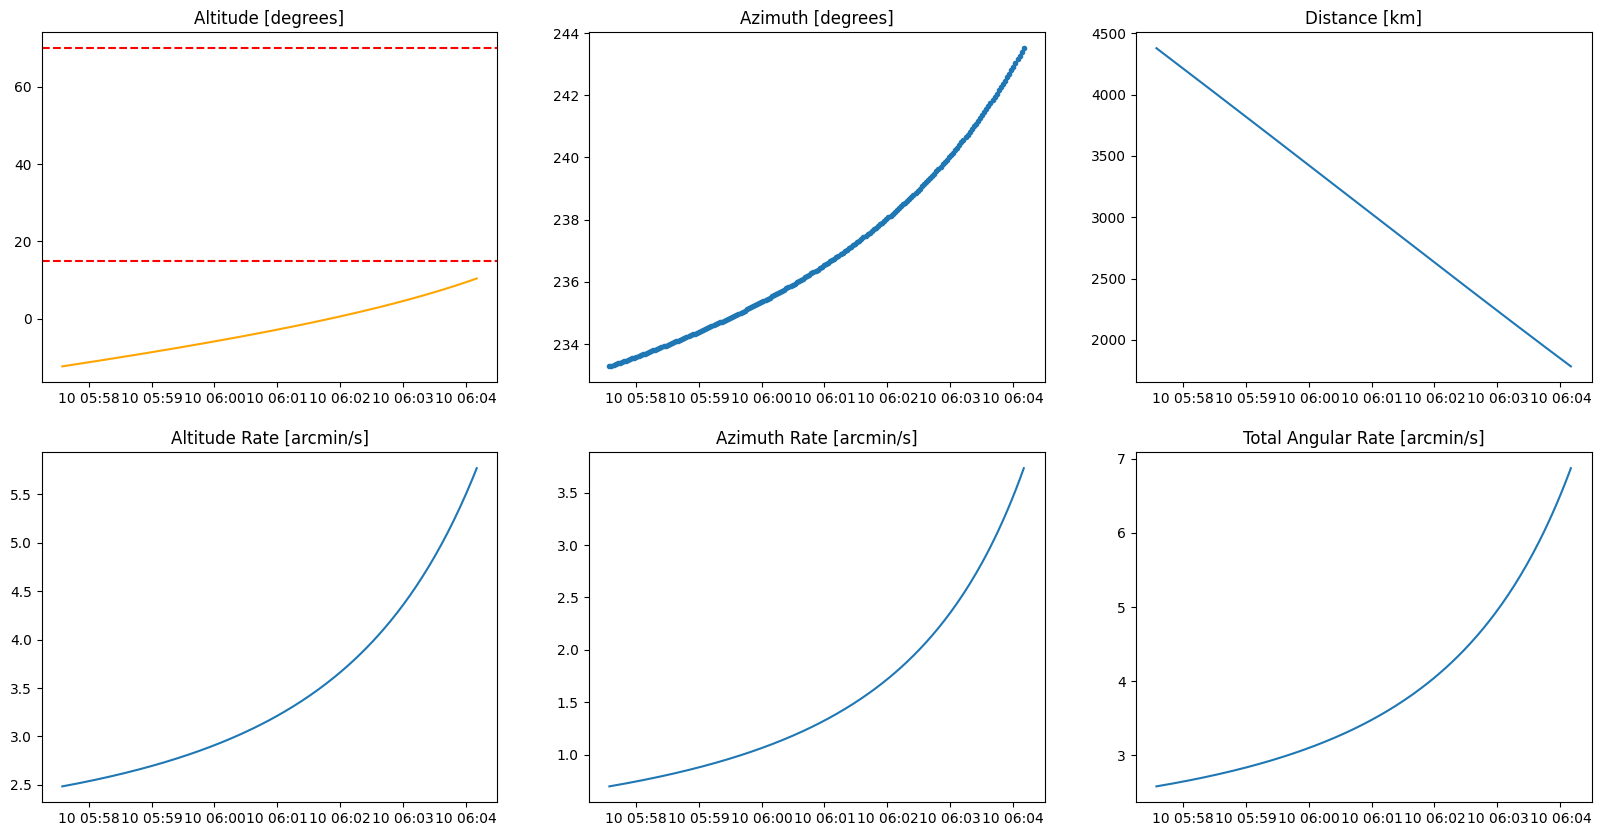

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if r['is_sunlit']])
ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if not r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if not r['is_sunlit']],
              color='orange')
ax[0][0].axhline(y=15, color='red', linestyle='--')
ax[0][0].axhline(y=70, color='red', linestyle='--')
ax[0][0].set_title("Altitude [degrees]")

ax[0][1].scatter([r['ts'].astimezone(tz) for r in pass_table], [az.degrees for az in pass_table['az']], marker='.')
ax[0][1].set_title("Azimuth [degrees]")

ax[0][2].plot([r['ts'].astimezone(tz) for r in pass_table], [dist.km for dist in pass_table['distance']])
ax[0][2].set_title("Distance [km]")

ax[1][0].plot([r['ts'].astimezone(tz) for r in pass_table], [alt_rate.arcminutes.per_second for alt_rate in pass_table['alt_rate']])
ax[1][0].set_title("Altitude Rate [arcmin/s]")

ax[1][1].plot([r['ts'].astimezone(tz) for r in pass_table], [az_rate.arcminutes.per_second for az_rate in pass_table['az_rate']]);
ax[1][1].set_title("Azimuth Rate [arcmin/s]")

#ax[1][2].plot(x, [range_rate.km_per_s for range_rate in pass_table['range_rate']]);
#ax[1][2].set_title("Range Rate [km/s]");

ax[1][2].plot([r['ts'].astimezone(tz) for r in pass_table], [rate.arcminutes.per_second for rate in pass_table['angular_rate']]);
ax[1][2].set_title("Total Angular Rate [arcmin/s]");


In [52]:
import requests
import json
import base64

r = requests.get('https://ssd.jpl.nasa.gov/api/horizons.api', params={
'MAKE_EPHEM': 'YES',
'COMMAND': '\'DES=3727039;\'',
'EPHEM_TYPE': 'SPK',
'OBJ_DATA': 'NO',
'START_TIME': '2020-01-01',
'STOP_TIME': '2030-12-31',
})

print(r.url)

res = json.loads(r.content)
with open('2015RN35.bsp', 'w+b') as f:
  f.write(base64.b64decode(res['spk']))

ModuleNotFoundError: No module named 'requests'

In [ ]:
from spktype21 import SPKType21
from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction

class Type21Object(VectorFunction):
    def __init__(self, kernel, target):
        self.kernel = kernel
        self.center = 10
        self.target = target

    def _at(self, t):
        k = self.kernel
        r, v = k.compute_type21(10, self.target, t.whole, t.tdb_fraction)
        return r / AU_KM, v / AU_KM, None, None

kernel = SPKType21.open('2015RN35.bsp')
rn35 = sun + Type21Object(kernel, 3727039)

In [ ]:

sun

<ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN>

In [ ]:
rn35

<VectorSum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 Type21Object 10 SUN -> 3727039>

In [ ]:
t = ts.utc(2022,12,18,5,0)

obs = (earth+raleigh).at(t).observe(rn35)

alt, az, distance, alt_rate, az_rate, range_rate = obs.frame_latlon_and_rates(raleigh)
_, _, _, dec_rate, ra_rate, _ = obs.frame_latlon_and_rates(framelib.true_equator_and_equinox_of_date)
ra, dec, _ = obs.radec()

altaz_rate = AngleRate._from_radians_per_day(
    math.sqrt(alt_rate.radians.per_day**2 + az_rate.radians.per_day**2))

radec_rate = AngleRate._from_radians_per_day(
    math.sqrt(ra_rate.radians.per_day**2 + dec_rate.radians.per_day**2))

print(f'Ra:  {ra}')
print(f'Dec: {dec}')
print(f'Ra Rate: {ra_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Dec Rate:  {dec_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Angular Velocity: {radec_rate.arcminutes.per_minute:.2f} arcmin/min')
print()
print(f'Alt: {alt.degrees:.2f} degrees')
print(f'Az:  {az.degrees:.2f} degrees')
print(f'Alt Rate: {alt_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Az Rate:  {az_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Total Alt/Az Rate: {altaz_rate.arcminutes.per_minute:.2f} arcmin/min')
print(f'Distance: {distance.au:.2f} AU')

In [ ]:
(earth+raleigh).at(t).observe(rn35).radec()

In [ ]:
(earth+raleigh).at(t+1/24/60).observe(rn35).radec()[0]._degrees

In [ ]:
ra._degrees - ra_rate.degrees.per_minute

In [ ]:
ra._degrees

In [ ]:
t+1/24/60

In [ ]:
altaz_rate.arcminutes.per_minute

In [ ]:
radec_rate.arcminutes.per_minute

In [ ]:
!wget https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT.gz

In [ ]:
!gunzip MPCORB.DAT.gz

In [ ]:
!grep ' 2015 RN35 ' MPCORB.DAT > MPCORB.excerpt.DAT

In [ ]:
from skyfield.data import mpc
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

with load.open('MPCORB.excerpt.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)

print(minor_planets.shape[0], 'minor planets loaded')
bad_orbits = minor_planets.semimajor_axis_au.isnull()
minor_planets = minor_planets[~bad_orbits]
minor_planets = minor_planets.set_index('designation', drop=False)
minor_planets

In [ ]:
row = minor_planets.loc['2015 RN35']
rn35_mpc = sun + mpc.mpcorb_orbit(row, ts, GM_SUN)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

# The Minor Planet Center data file provides the comet orbit.

with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/modern_iau/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[12, 12])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
));